In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [34]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/datasets/masoudnickparvar/brain-tumor-mri-dataset


In [35]:
import numpy as np
import tensorflow as tf
import os

In [36]:
train_path='/kaggle/input/datasets/masoudnickparvar/brain-tumor-mri-dataset/Training'
IMG_SIZE=260
BATCH_SIZE=32

train_ds=tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds=tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 5600 files belonging to 4 classes.
Using 4480 files for training.
Found 5600 files belonging to 4 classes.
Using 1120 files for validation.


In [37]:
for image, label in train_ds.take(1):
    print(image.shape)
    print(label.shape)

(32, 260, 260, 3)
(32, 4)


In [38]:
from tensorflow.keras.applications.efficientnet import preprocess_input

train_ds=train_ds.prefetch(tf.data.AUTOTUNE)
val_ds=val_ds.map(lambda x, y: (preprocess_input(x),y)).shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [39]:
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras import layers, models

In [40]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

In [41]:
base_model=EfficientNetB2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)
base_model.trainable=False

In [42]:
inputs=tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))

x=data_augmentation(inputs)
x=base_model(x, training=False)
x=layers.GlobalAveragePooling2D()(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(0.3)(x)
outputs=layers.Dense(4, activation='softmax')(x)

model=tf.keras.Model(inputs, outputs)

In [43]:
callbacks=[
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=5,
        factor=0.3,
        verbose=1
    )
]

In [44]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.004),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [45]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10


E0000 00:00:1771077647.025229      55 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_4_1/efficientnetb2_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


140/140 ━━━━━━━━━━━━━━━━━━━━ 35s 152ms/step - accuracy: 0.7260 - loss: 0.8619 - val_accuracy: 0.8768 - val_loss: 0.3720 - learning_rate: 0.0040
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.8223 - loss: 0.5329 - val_accuracy: 0.8839 - val_loss: 0.3137 - learning_rate: 0.0040
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - accuracy: 0.8439 - loss: 0.4932 - val_accuracy: 0.8866 - val_loss: 0.3366 - learning_rate: 0.0040
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - accuracy: 0.8534 - loss: 0.4657 - val_accuracy: 0.8768 - val_loss: 0.3662 - learning_rate: 0.0040
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.8496 - loss: 0.5145 - val_accuracy: 0.8482 - val_loss: 0.4565 - learning_rate: 0.0040
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.8401 - loss: 0.5174 - val_accuracy: 0.9009 - val_loss: 0.2956 - learning_rate: 0.0040
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.8633 - loss:

In [47]:
import numpy as np

class_counts = np.bincount(
    np.concatenate([y.numpy().argmax(axis=1) for x, y in train_ds])
)
print(class_counts)

[1140 1125 1100 1115]


In [48]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(confusion_matrix(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [50]:
for layer in base_model.layers[:-30]:
    layer.trainable=True

In [51]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [52]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

Epoch 1/10


E0000 00:00:1771078211.357697      55 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_4_1/efficientnetb2_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


140/140 ━━━━━━━━━━━━━━━━━━━━ 129s 572ms/step - accuracy: 0.6882 - loss: 1.1650 - val_accuracy: 0.8196 - val_loss: 0.5869
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 540ms/step - accuracy: 0.8062 - loss: 0.6819 - val_accuracy: 0.7973 - val_loss: 0.6715
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 77s 548ms/step - accuracy: 0.8345 - loss: 0.5918 - val_accuracy: 0.8143 - val_loss: 0.6374
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 546ms/step - accuracy: 0.8466 - loss: 0.5420 - val_accuracy: 0.8625 - val_loss: 0.4601
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 546ms/step - accuracy: 0.8546 - loss: 0.5159 - val_accuracy: 0.8768 - val_loss: 0.3796
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 546ms/step - accuracy: 0.8733 - loss: 0.3969 - val_accuracy: 0.8955 - val_loss: 0.3295
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 546ms/step - accuracy: 0.8800 - loss: 0.3989 - val_accuracy: 0.8938 - val_loss: 0.3313
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 545ms/step - accuracy: 0.8920 - loss: 0.3641 - va

In [63]:
class_names = sorted(os.listdir(test_path))
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [75]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

IMG_SIZE = 260

img_path = '/kaggle/input/datasets/masoudnickparvar/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_106.jpg'

img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

In [76]:
from tensorflow.keras.applications.efficientnet import preprocess_input

img_array = preprocess_input(img_array)

In [77]:
prediction = model.predict(img_array)

predicted_class = class_names[np.argmax(prediction)]
confidence = np.max(prediction) * 100

print("Predicted:", predicted_class)
print("Confidence:", round(confidence, 2), "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted: pituitary
Confidence: 99.97 %


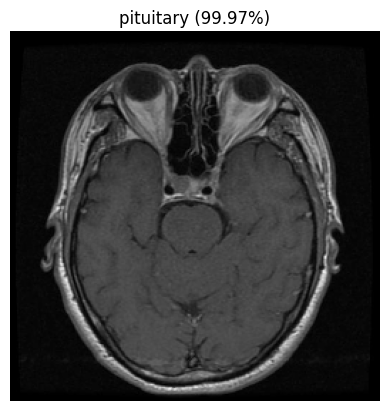

In [78]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f"{predicted_class} ({confidence:.2f}%)")
plt.axis("off")
plt.show()

In [79]:
model.save('brain_tumor_classification.h5')